# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp

import rapids_singlecell.scanpy_gpu_funcs as rsf
from rapids_singlecell.cunnData import cunnData

import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5




In [2]:
import rmm
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")



CPU times: user 2.58 s, sys: 97.4 ms, total: 2.68 s
Wall time: 2.67 s


In [5]:
%%time
cudata = cunnData(adata=adata)

CPU times: user 1.29 s, sys: 576 ms, total: 1.86 s
Wall time: 1.86 s


In [6]:
cudata.nnz

114212920

In [7]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 4.557352066040039


## Preprocessing

In [8]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [9]:
%%time
cudata.flag_gene_family(gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 8.63 ms, sys: 361 µs, total: 8.99 ms
Wall time: 8.62 ms


In [10]:
%%time
cudata.flag_gene_family(gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 6.45 ms, sys: 0 ns, total: 6.45 ms
Wall time: 6.34 ms


In [11]:
%%time
cudata.caluclate_qc(qc_vars=["MT","RIBO"])

CPU times: user 257 ms, sys: 43.9 ms, total: 301 ms
Wall time: 298 ms


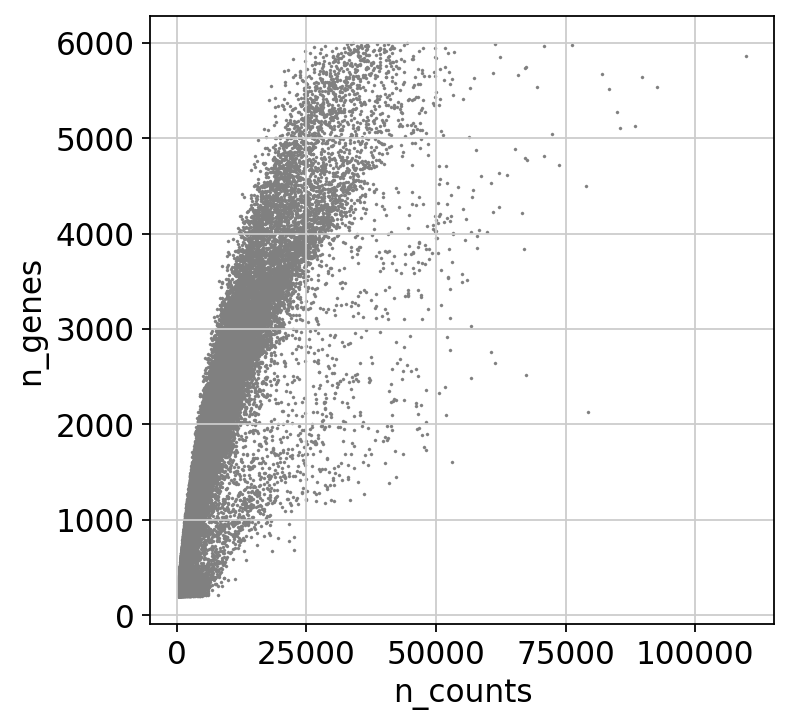

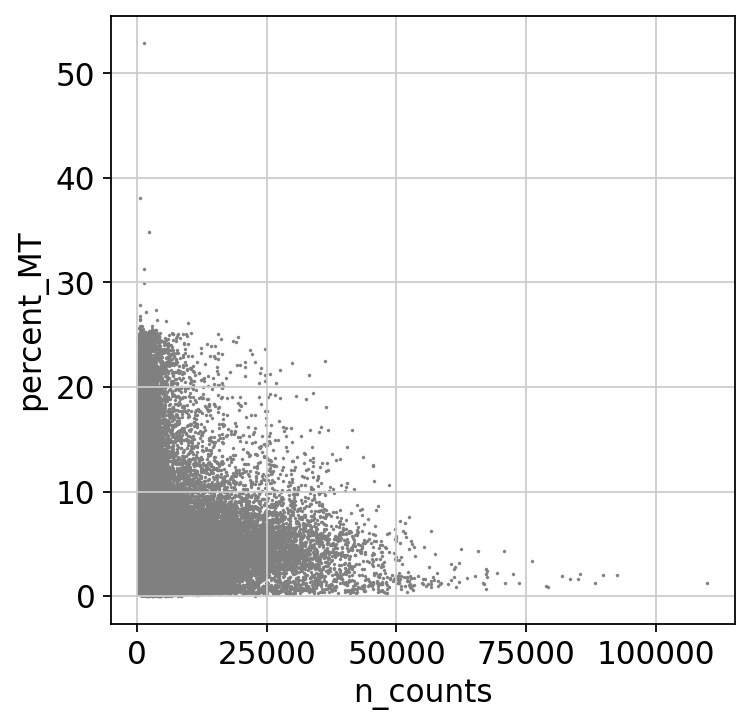

In [12]:
rsf.plt_scatter(cudata,"n_counts","n_genes")
rsf.plt_scatter(cudata,"n_counts","percent_MT")

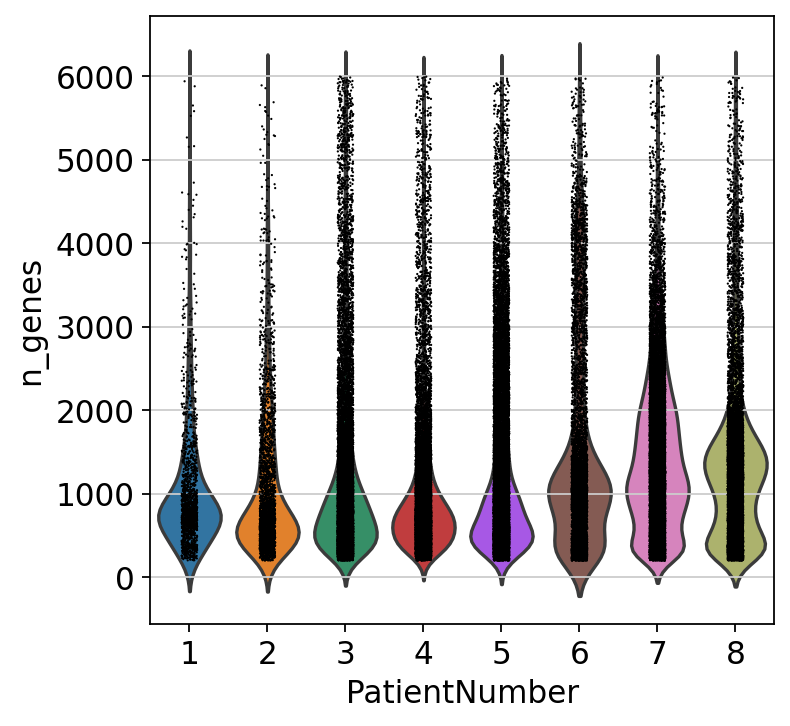

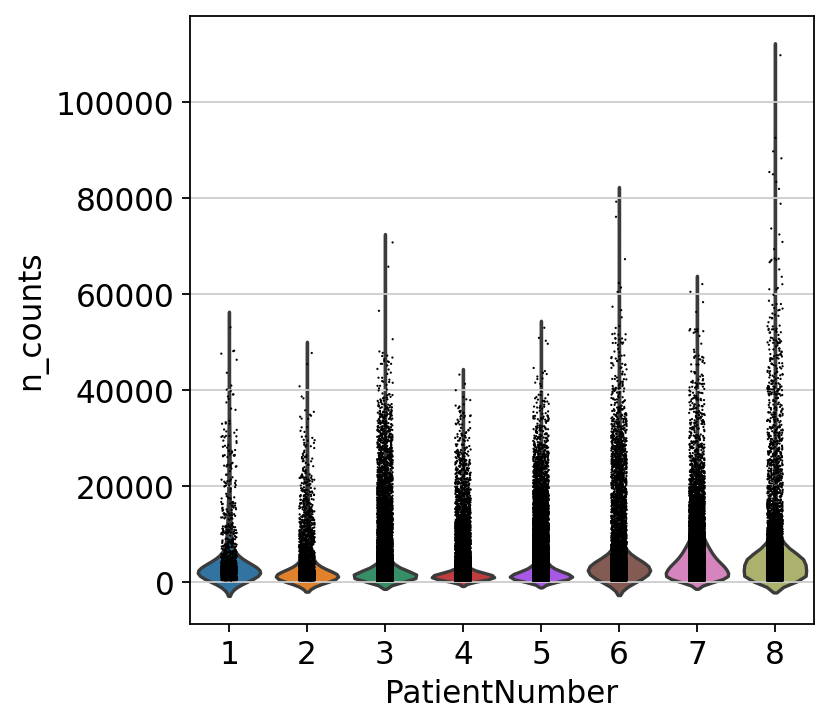

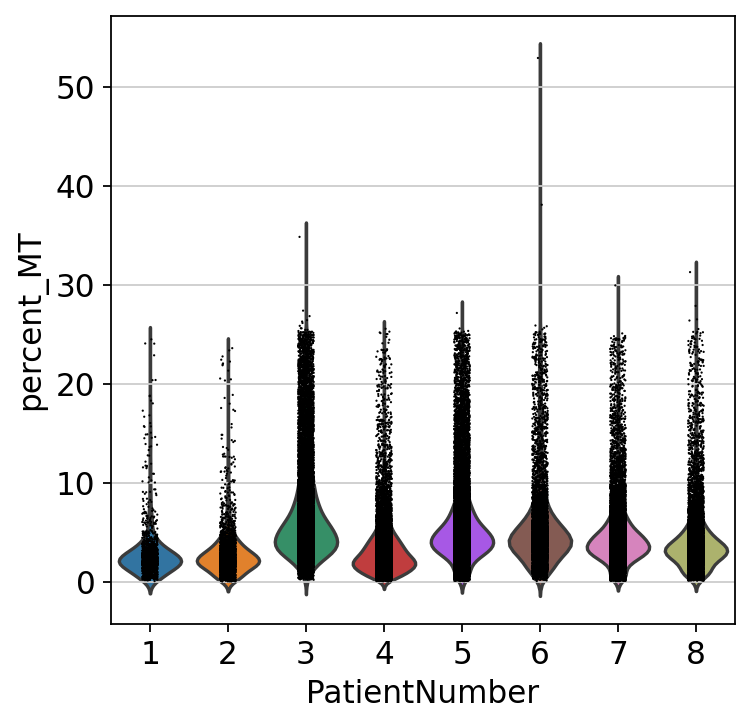

In [13]:
rsf.plt_violin(cudata,key="n_genes",groupby="PatientNumber")
rsf.plt_violin(cudata,key="n_counts",groupby="PatientNumber")
rsf.plt_violin(cudata,key="percent_MT",groupby="PatientNumber")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

The size of our count matrix is now reduced.

In [14]:
%%time
cudata = cudata[cudata.obs["n_genes"] < 5000]
cudata = cudata[cudata.obs["percent_MT"] < 20]

CPU times: user 16.4 ms, sys: 12.8 ms, total: 29.2 ms
Wall time: 28.2 ms


We also filter out genes that are expressed in less than 3 cells.

In [15]:
%%time
cudata.filter_genes(min_count=3)

filtered out 8034 genes based on n_cells
CPU times: user 44.5 ms, sys: 0 ns, total: 44.5 ms
Wall time: 43.8 ms


In [16]:
cudata.shape

(91068, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [17]:
%%time
cudata.normalize_total(target_sum=1e4)

CPU times: user 1.06 ms, sys: 0 ns, total: 1.06 ms
Wall time: 594 µs


Next, we log transform the count matrix.

In [18]:
%%time
cudata.log1p()

CPU times: user 4.34 ms, sys: 167 µs, total: 4.51 ms
Wall time: 3.6 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `cell_ranger` for selecting highly variable genes based on the log normalized counts in `.X`

In [19]:
%%time
cudata.highly_varible_genes(n_top_genes=5000,flavor="cell_ranger", batch_key="PatientNumber")

/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/rapids_singlecell/cunnData.py:709: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg_inter.append(missing_hvg, ignore_index=True)
/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/rapids_singlecell/cunnData.py:709: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg_inter.append(missing_hvg, ignore_index=True)
/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/rapids_singlecell/cunnData.py:709: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg_inter.append(missing_hvg, ignore_index=True)
/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/rapids_singlecell/cunnData.py:709: FutureWarning: The frame.a

CPU times: user 1.91 s, sys: 83.5 ms, total: 1.99 s
Wall time: 1.99 s


/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/rapids_singlecell/cunnData.py:740: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.highly_variable.iloc[:n_top_genes] = True


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [20]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 166 ms, sys: 64.2 ms, total: 231 ms
Wall time: 228 ms


Now we restrict our cunndata object to the highly variable genes.

In [21]:
%%time
cudata.filter_highly_variable()

CPU times: user 16.8 ms, sys: 5.29 ms, total: 22.1 ms
Wall time: 20.7 ms


Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [22]:
%%time
cudata.regress_out(keys=["n_counts", "percent_MT"])

CPU times: user 7.85 s, sys: 5.03 s, total: 12.9 s
Wall time: 12.9 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [23]:
%%time
cudata.scale(max_value=10)

CPU times: user 110 ms, sys: 1.92 ms, total: 111 ms
Wall time: 110 ms


Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [24]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 260 ms, sys: 195 ms, total: 455 ms
Wall time: 453 ms


In [25]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 18.049681186676025


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [26]:
%%time
rsf.pca(adata, n_comps = 100)

CPU times: user 1.04 s, sys: 509 ms, total: 1.55 s
Wall time: 1.55 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

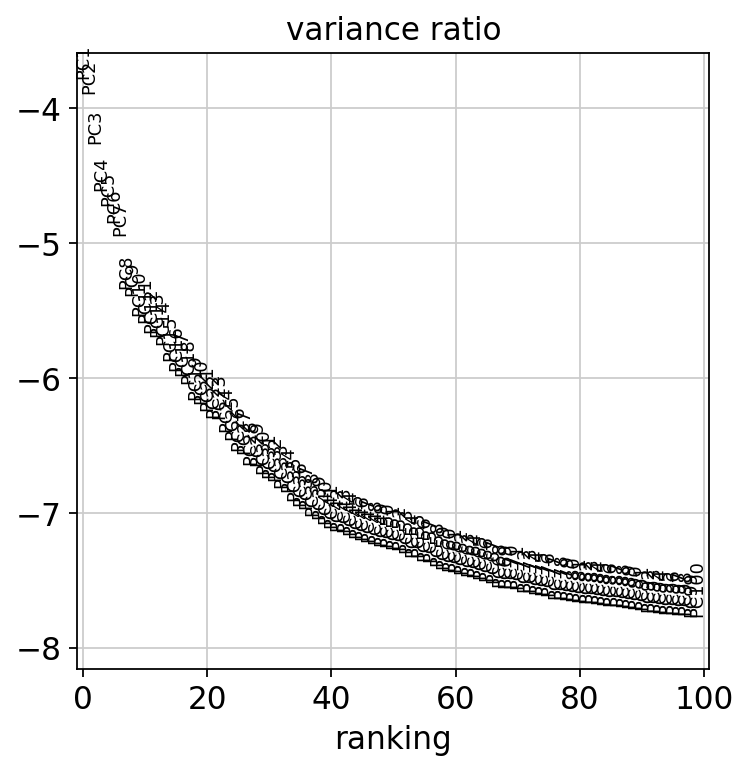

In [27]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [28]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 4.89 s, sys: 51.4 ms, total: 4.94 s
Wall time: 4.92 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [29]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 432 ms, sys: 22.5 ms, total: 454 ms
Wall time: 453 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering. As of the time of writing this notebook there is a known small bug in scanpy. The resoltion parameter of Louvain is not correctly passed to the cugraph funciton. This results in the resoltion beeing looked at 1.0.
Since the bug is fixed you can use `scanpy_gpu_funcs` implementation of Louvain.
Leiden clustering using Rapids has not been implemented in scanpy. You can also use `scanpy_gpu_funcs` implementation of the Leiden algorithm.

In [30]:
%%time
rsf.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 106 ms, sys: 8.8 ms, total: 115 ms
Wall time: 114 ms


In [31]:
%%time
rsf.leiden(adata,resolution=0.6)

CPU times: user 109 ms, sys: 13.4 ms, total: 123 ms
Wall time: 121 ms


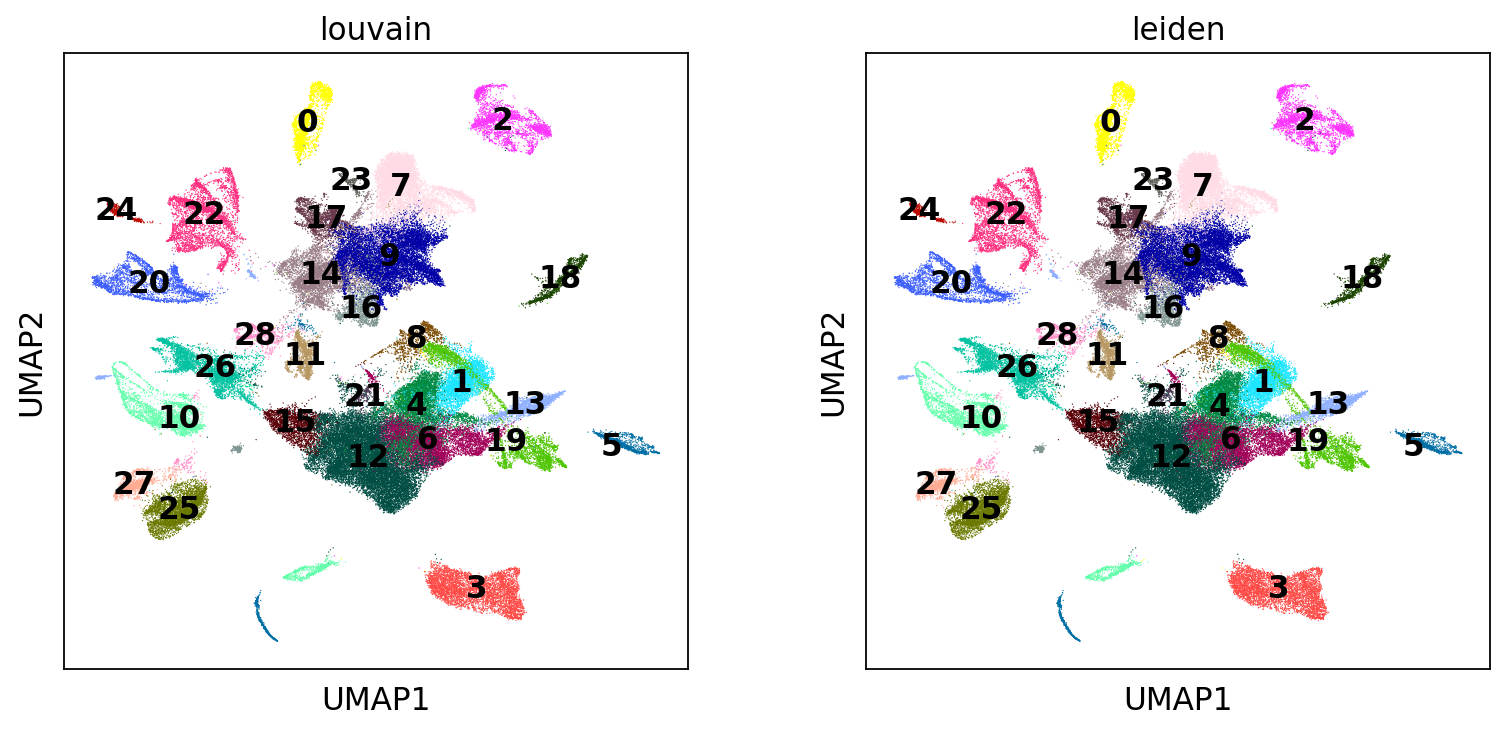

CPU times: user 758 ms, sys: 156 ms, total: 914 ms
Wall time: 720 ms


In [32]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

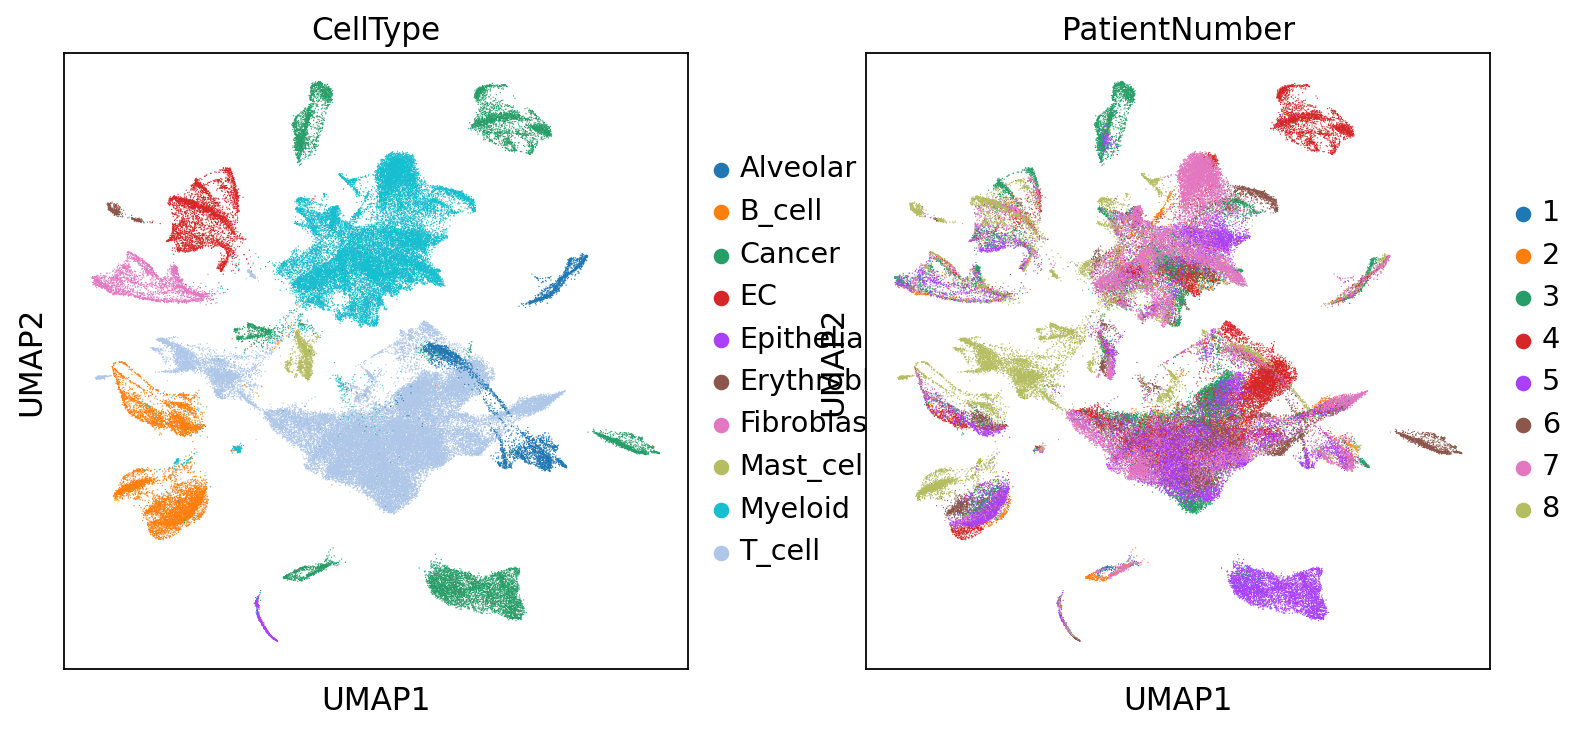

In [33]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [34]:
%%time
rsf.tsne(adata, n_pcs = 40,perplexity=30,early_exaggeration=12, learning_rate=200)

/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [12:22:59.166734] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.25 s, sys: 15.7 ms, total: 1.27 s
Wall time: 1.26 s


In [35]:
rsf.kmeans(adata, n_clusters=8)

/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


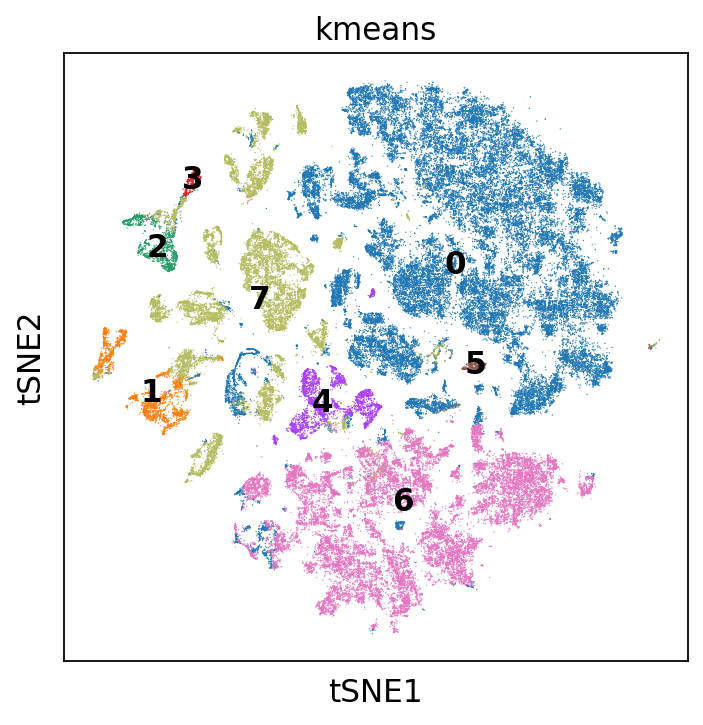

CPU times: user 408 ms, sys: 163 ms, total: 571 ms
Wall time: 377 ms


In [36]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

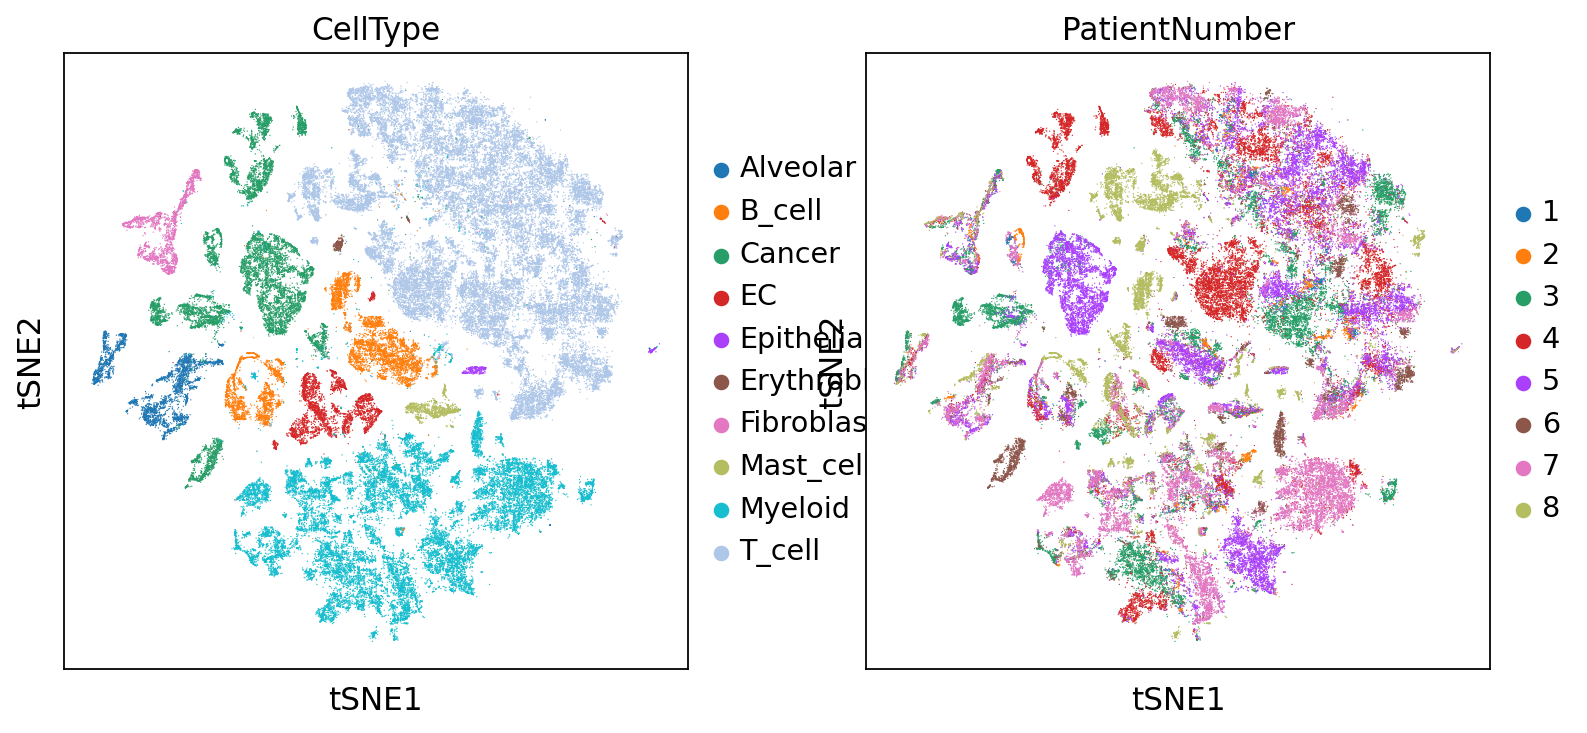

In [37]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [38]:
%%time
rsf.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

[W] [12:23:05.087407] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
CPU times: user 2.71 s, sys: 502 ms, total: 3.21 s
Wall time: 3.2 s


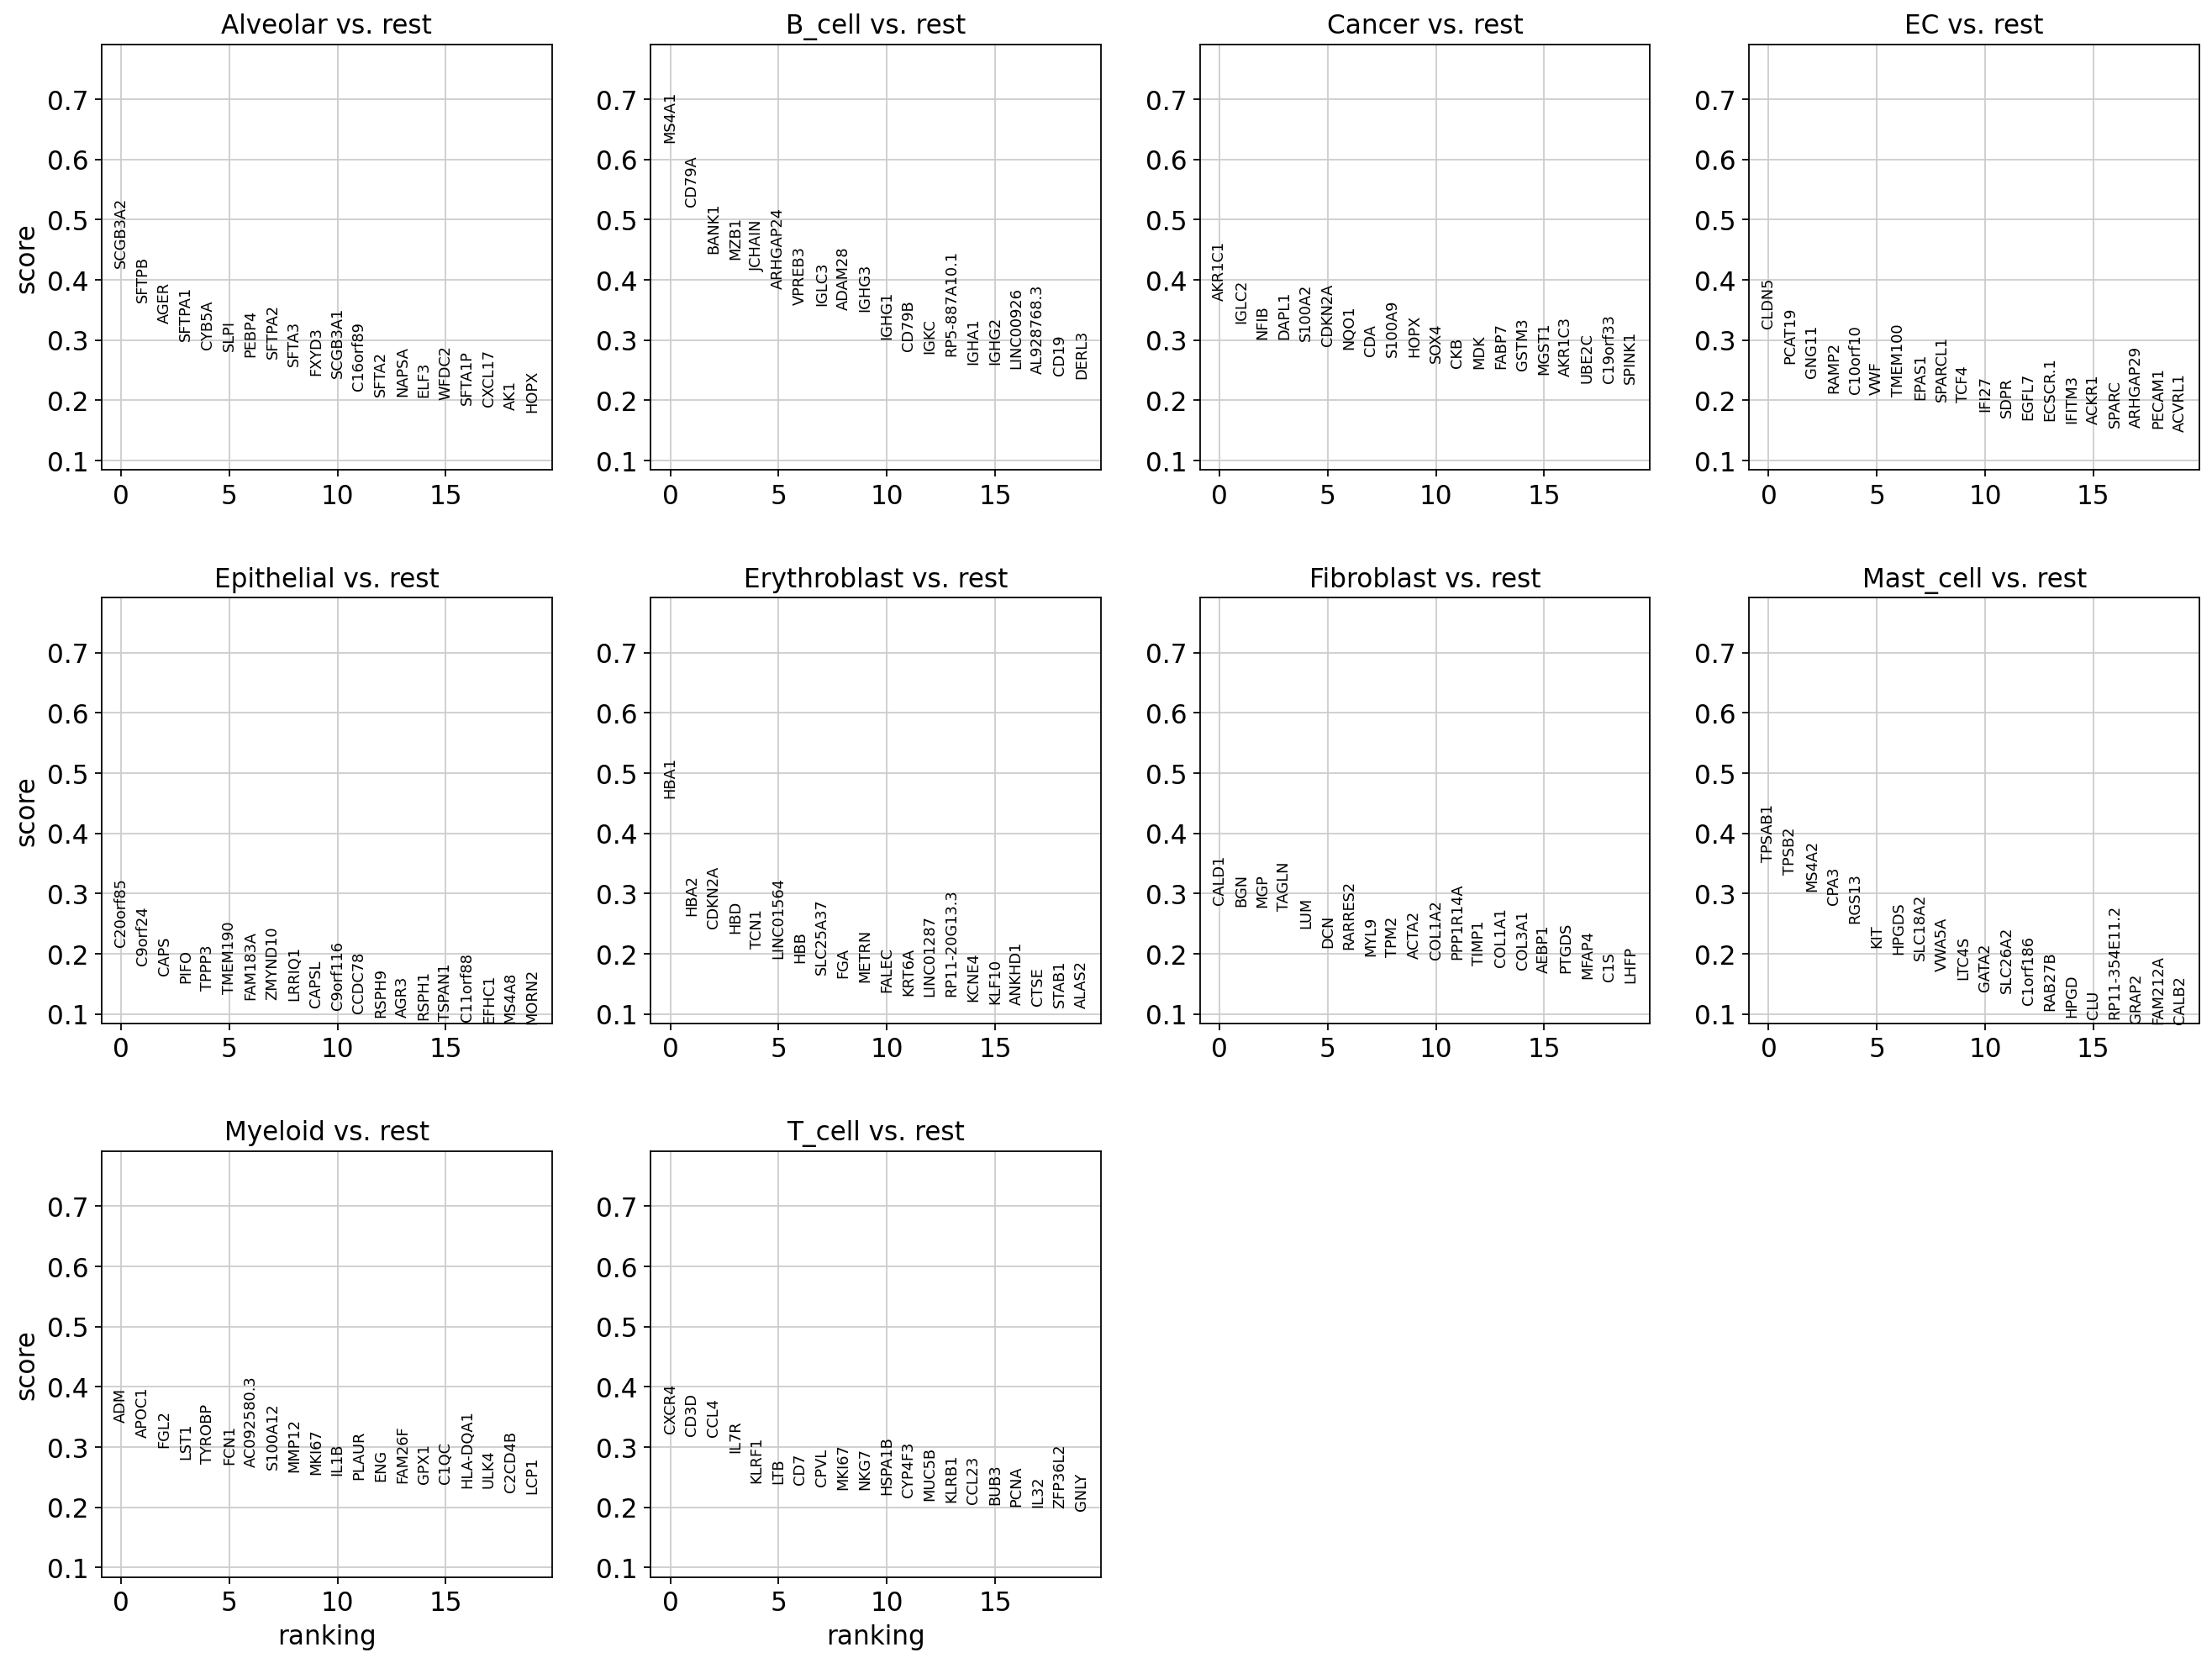

CPU times: user 1.05 s, sys: 282 ms, total: 1.33 s
Wall time: 1.01 s


In [39]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [40]:
post_time = time.time()

In [41]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 15.953731536865234


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [42]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

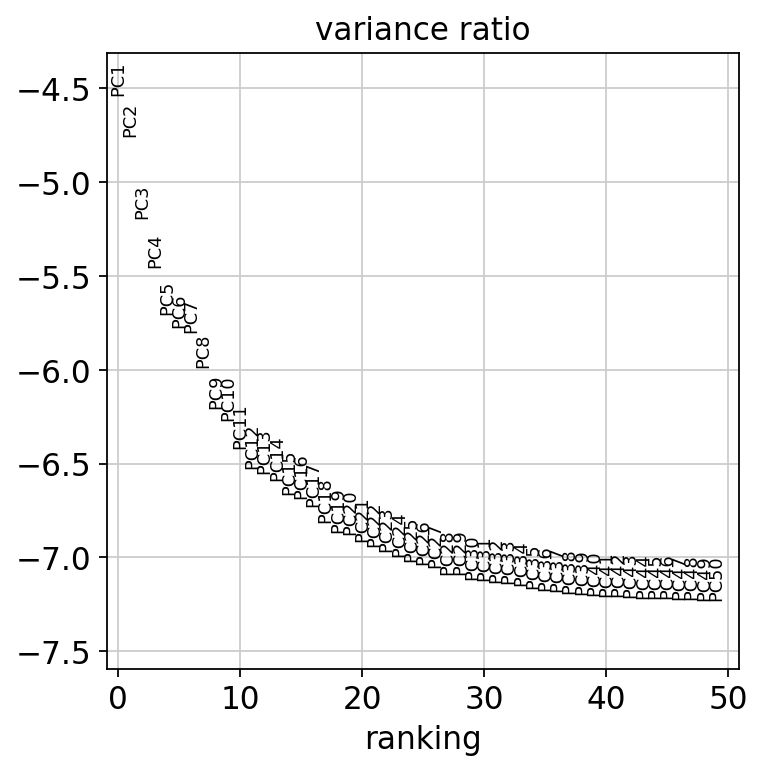

CPU times: user 820 ms, sys: 455 ms, total: 1.28 s
Wall time: 1.06 s


In [43]:
%%time
rsf.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [44]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20, method='rapids')
sc.tl.umap(tdata, method='rapids')
rsf.louvain(tdata)

CPU times: user 1.08 s, sys: 264 ms, total: 1.35 s
Wall time: 905 ms


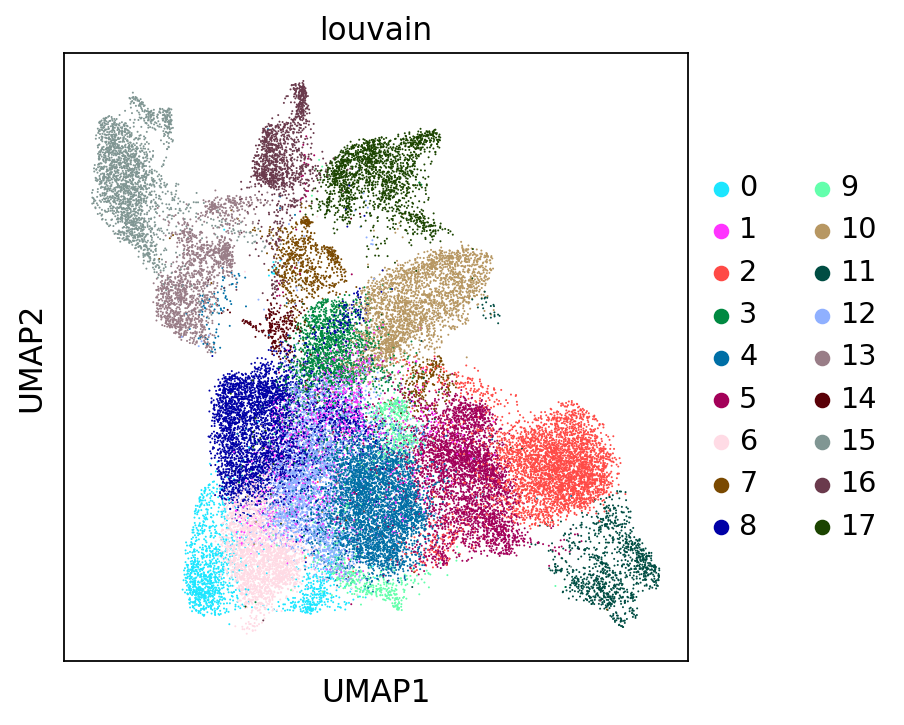

In [45]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [46]:
%%time
rsf.diffmap(tdata)

CPU times: user 913 ms, sys: 2.29 s, total: 3.21 s
Wall time: 303 ms


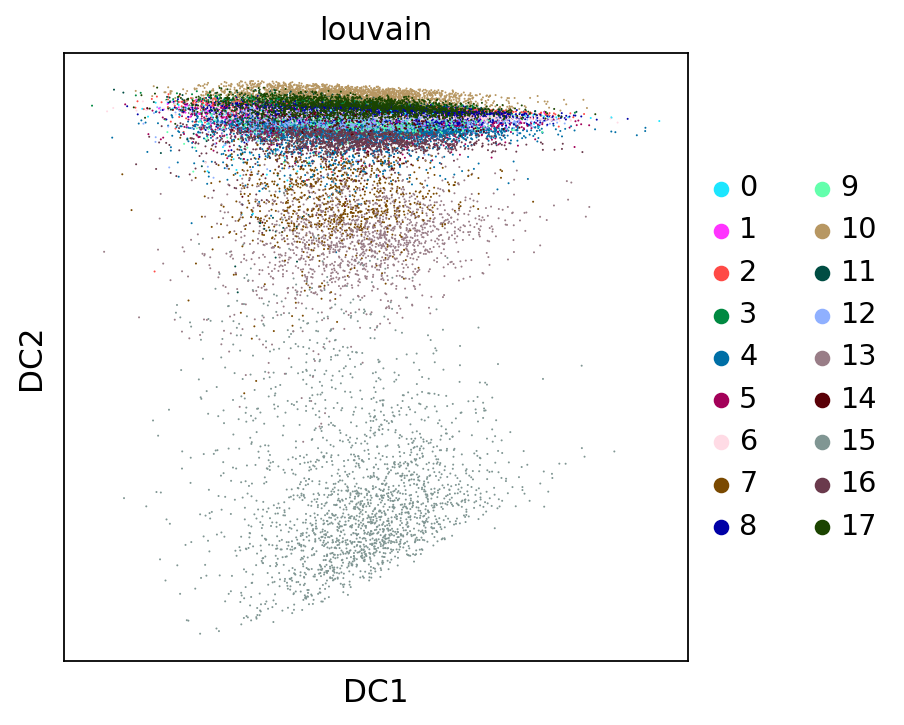

In [47]:
sc.pl.diffmap(tdata, color='louvain')

In [48]:
%%time
rsf.draw_graph(tdata)

CPU times: user 333 ms, sys: 224 µs, total: 334 ms
Wall time: 332 ms


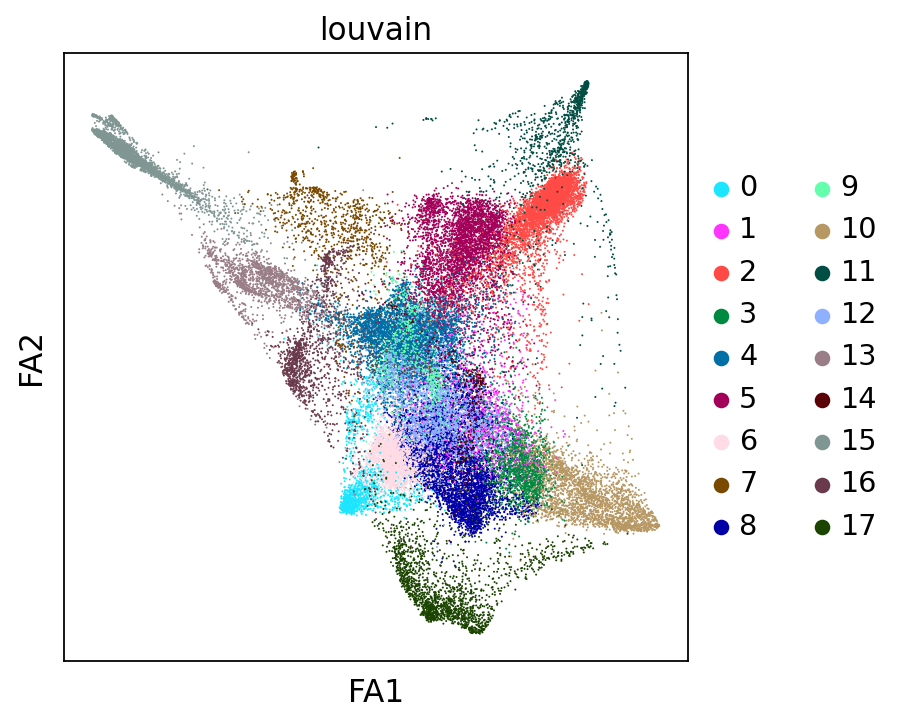

In [49]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [50]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 38.01545429229736
